In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
from skimage import feature, measure, filters, morphology, segmentation
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from skimage.segmentation import clear_border
from scipy import ndimage
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft2
from tqdm import tqdm
import pickle
import json

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Configuración y Carga de Datos

In [16]:
# Cargar configuración del notebook anterior
with open(Path.cwd().parent / 'config.pkl', 'rb') as f:
    config = pickle.load(f)

PROJECT_ROOT = Path(config['PROJECT_ROOT'])
DATA_PATH = Path(config['DATA_PATH'])
PROCESSED_DATA_PATH = Path(config['PROCESSED_DATA_PATH'])
RESULTS_PATH = Path(config['RESULTS_PATH'])
IMG_SIZE = config['IMG_SIZE']
RANDOM_SEED = config['RANDOM_SEED']

# Crear directorio para características
FEATURES_PATH = PROJECT_ROOT / 'data' / 'features'
FEATURES_PATH.mkdir(parents=True, exist_ok=True)

print(f"Proyecto: {PROJECT_ROOT}")
print(f"Características: {FEATURES_PATH}")

Proyecto: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia
Características: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\data\features


In [17]:
# Cargar información del dataset
def load_dataset_info(data_path):
    """Carga información básica del dataset."""
    dataset_info = {
        'train': {'NORMAL': [], 'PNEUMONIA': []},
        'test': {'NORMAL': [], 'PNEUMONIA': []},
        'val': {'NORMAL': [], 'PNEUMONIA': []}
    }
    
    chest_xray_path = data_path / 'chest_xray'
    
    if not chest_xray_path.exists():
        print(f"No se encontró el dataset en {chest_xray_path}")
        return None
    
    for split in ['train', 'test', 'val']:
        split_path = chest_xray_path / split
        if split_path.exists():
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = split_path / class_name
                if class_path.exists():
                    images = list(class_path.glob('*.jpeg')) + \
                            list(class_path.glob('*.jpg')) + \
                            list(class_path.glob('*.png'))
                    dataset_info[split][class_name] = images
    
    return dataset_info

dataset_info = load_dataset_info(DATA_PATH)
print(f"Dataset cargado: {sum(len(dataset_info[split][cls]) for split in ['train', 'test', 'val'] for cls in ['NORMAL', 'PNEUMONIA'])} imágenes")

Dataset cargado: 5856 imágenes


In [18]:
def preprocess_image(img_path, target_size=(224, 224)):
    """Aplica el pipeline de preprocesamiento a una imagen."""
    try:
        pil_img = Image.open(img_path)
        if pil_img.mode != 'L':
            pil_img = pil_img.convert('L')
        
        resized_pil = pil_img.resize(target_size, Image.Resampling.LANCZOS)
        resized_array = np.array(resized_pil, dtype=np.uint8)
        
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        clahe_array = clahe.apply(resized_array)
        
        normalized_array = clahe_array.astype(np.float32) / 255.0
        
        return normalized_array
        
    except Exception as e:
        print(f"Error procesando {img_path}: {e}")
        return None

## 2. Descriptores de Forma

### 2.1 HOG (Histogram of Oriented Gradients)

Características HOG extraídas: 26244 dimensiones


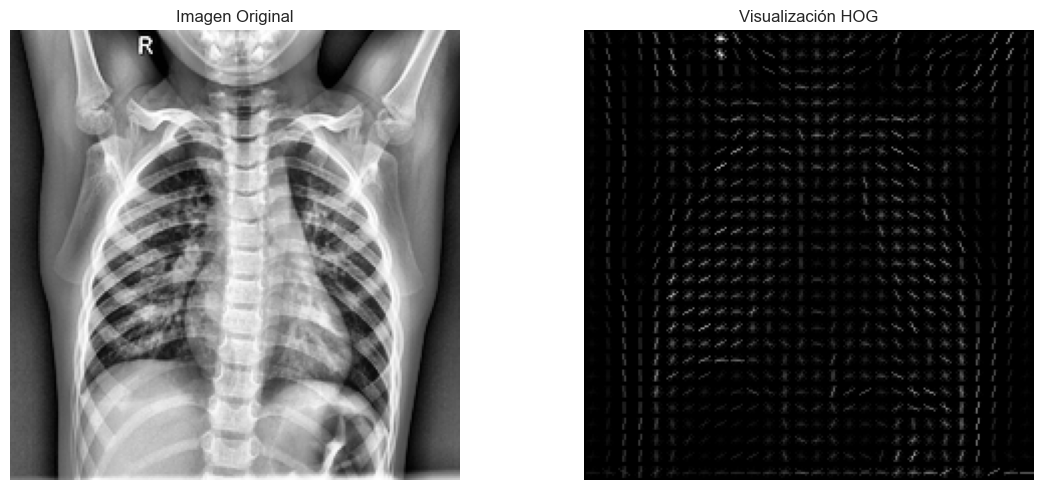

In [19]:
def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Extrae características HOG de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
        orientations: Número de orientaciones en el histograma
        pixels_per_cell: Tamaño de cada celda en píxeles
        cells_per_block: Número de celdas en cada bloque
    
    Returns:
        numpy.ndarray: Vector de características HOG
    """
    try:
        hog_features = hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False,
            feature_vector=True
        )
        return hog_features
    except Exception as e:
        print(f"Error extrayendo HOG: {e}")
        return None

# Demostrar extracción HOG
if dataset_info:
    sample_img_path = dataset_info['train']['NORMAL'][0]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        hog_features = extract_hog_features(sample_img)
        print(f"Características HOG extraídas: {len(hog_features)} dimensiones")
        
        # Visualizar HOG
        hog_features_vis, hog_image = hog(
            sample_img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(sample_img, cmap='gray')
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(hog_image, cmap='gray')
        axes[1].set_title('Visualización HOG')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / 'hog_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()

Extrajo 26,244 dimensiones de características, que es bastante robusto.

Se puede ver cómo el algoritmo detecta los gradientes y orientaciones en la radiografía. En la imagen HOG de la derecha, las líneas blancas muestran las direcciones predominantes de los bordes: las costillas parecen como líneas diagonales, la columna vertebral es una línea vertical clara en el centro, y los bordes de los pulmones se ven como contornos curvos.

HOG está capturando las estructuras anatómicas importantes las costillas, la forma de los pulmones, la columna vertebral. Estas características van a ser muy útiles para distinguir entre radiografías normales y con neumonía, ya que la neumonía cambia los patrones de textura y los bordes dentro de los pulmones.

### 2.2 Momentos de Hu

Momentos de Hu extraídos: 7 momentos
Valores: [-2.94812258 -7.58111001 -9.97506817 -9.98307894 10.         -9.99999723
 10.        ]


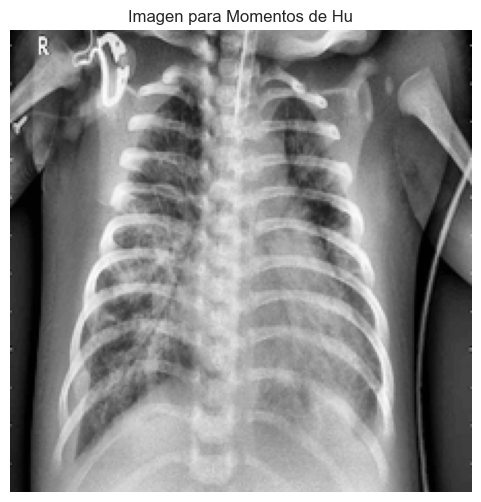

In [20]:
def extract_hu_moments(image):
    """
    Extrae los 7 momentos de Hu de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
    
    Returns:
        numpy.ndarray: Vector de 7 momentos de Hu
    """
    try:
        # Convertir a uint8 si es necesario
        if image.dtype != np.uint8:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image
        
        # Calcular momentos
        moments = cv2.moments(image_uint8)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Aplicar transformación logarítmica para estabilizar los valores
        hu_moments_log = np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        return hu_moments_log
    except Exception as e:
        print(f"Error extrayendo momentos de Hu: {e}")
        return None

# Demostrar extracción de momentos de Hu
if dataset_info:
    sample_img_path = dataset_info['train']['PNEUMONIA'][0]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        hu_moments = extract_hu_moments(sample_img)
        print(f"Momentos de Hu extraídos: {len(hu_moments)} momentos")
        print(f"Valores: {hu_moments}")
        
        # Visualizar imagen
        plt.figure(figsize=(6, 6))
        plt.imshow(sample_img, cmap='gray')
        plt.title('Imagen para Momentos de Hu')
        plt.axis('off')
        plt.savefig(RESULTS_PATH / 'hu_moments_sample.png', dpi=300, bbox_inches='tight')
        plt.show()

Los valores que vemos son interesantes: algunos son negativos (como -2.94 y -7.58) y otros llegan al máximo de 10 (que es el límite que se definio en el algoritmo). Esto es normal porque los momentos de Hu pueden tener valores muy grandes o muy pequeños, por eso aplicamos la transformación logarítmica.

Esta imagen de neumonía que está analizando muestra claramente las áreas más densas y opacas en los pulmones (se ven más blancas), y los momentos de Hu van a capturar la "forma general" de esa distribución de densidad de manera que sea consistente independientemente de cómo esté orientada la imagen.

### 2.3 Descriptores de Contorno

Descriptores de contorno extraídos:
  area: 22372.0000
  perimeter: 4242.9356
  eccentricity: 0.5737
  solidity: 0.6032
  extent: 0.5643
  aspect_ratio: 1.0980
  compactness: 64.0351


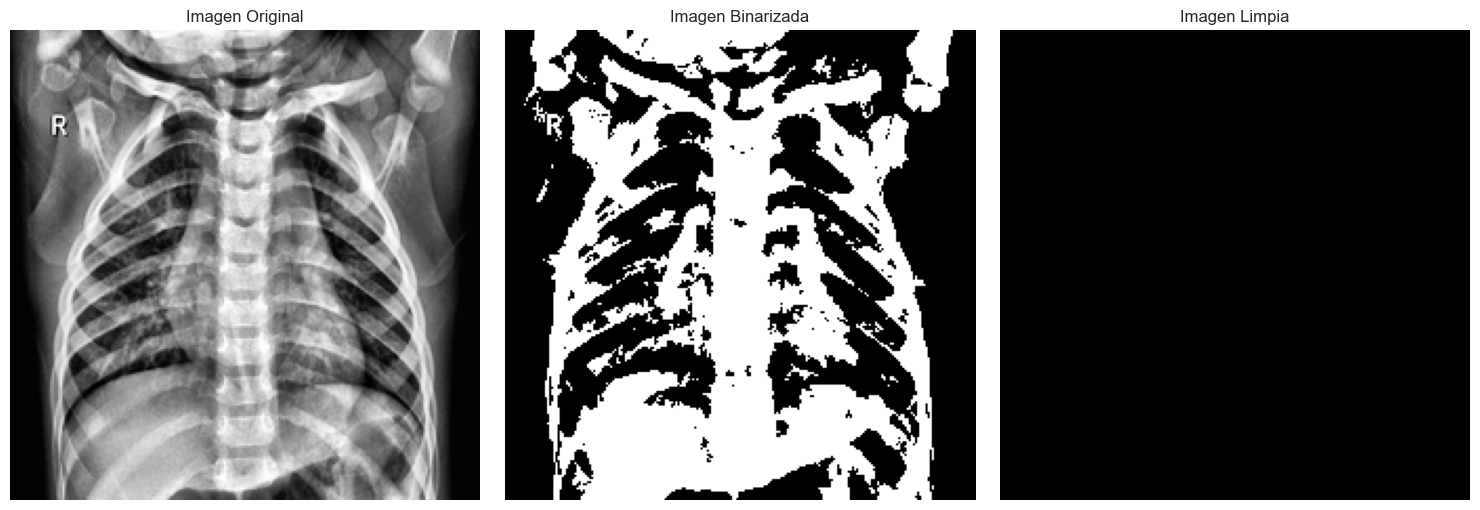

In [21]:
def extract_contour_features(image, threshold=0.5):
    """
    Extrae descriptores de contorno de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
        threshold: Umbral para binarización
    
    Returns:
        dict: Diccionario con descriptores de contorno
    """
    try:
        # Binarizar imagen
        binary = image > threshold
        
        # Limpiar bordes y objetos pequeños
        binary_clean = clear_border(binary)
        binary_clean = morphology.remove_small_objects(binary_clean, min_size=100)
        
        # Calcular propiedades de regiones
        labeled = measure.label(binary_clean)
        props = measure.regionprops(labeled)
        
        if len(props) == 0:
            # Si no se encuentran regiones, usar toda la imagen
            binary_clean = image > np.mean(image)
            labeled = measure.label(binary_clean)
            props = measure.regionprops(labeled)
        
        if len(props) > 0:
            # Tomar la región más grande
            largest_region = max(props, key=lambda x: x.area)
            
            contour_features = {
                'area': largest_region.area,
                'perimeter': largest_region.perimeter,
                'eccentricity': largest_region.eccentricity,
                'solidity': largest_region.solidity,
                'extent': largest_region.extent,
                'aspect_ratio': largest_region.bbox[2] / largest_region.bbox[3] if largest_region.bbox[3] > 0 else 0,
                'compactness': (largest_region.perimeter ** 2) / (4 * np.pi * largest_region.area) if largest_region.area > 0 else 0
            }
        else:
            # Valores por defecto si no se puede extraer contorno
            contour_features = {
                'area': 0,
                'perimeter': 0,
                'eccentricity': 0,
                'solidity': 0,
                'extent': 0,
                'aspect_ratio': 1,
                'compactness': 0
            }
        
        return contour_features
    except Exception as e:
        print(f"Error extrayendo descriptores de contorno: {e}")
        return None

# Demostrar extracción de descriptores de contorno
if dataset_info:
    sample_img_path = dataset_info['train']['NORMAL'][1]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        contour_features = extract_contour_features(sample_img)
        print("Descriptores de contorno extraídos:")
        for key, value in contour_features.items():
            print(f"  {key}: {value:.4f}")
        
        # Visualizar binarización
        binary = sample_img > 0.5
        binary_clean = clear_border(binary)
        binary_clean = morphology.remove_small_objects(binary_clean, min_size=100)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(sample_img, cmap='gray')
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(binary, cmap='gray')
        axes[1].set_title('Imagen Binarizada')
        axes[1].axis('off')
        
        axes[2].imshow(binary_clean, cmap='gray')
        axes[2].set_title('Imagen Limpia')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / 'contour_features_demo.png', dpi=300, bbox_inches='tight')
        plt.show()

Los valores extraídos nos dan información muy específica sobre la geometría de la radiografía:

- Área: 22,372 píxeles - bastante grande, indica que se detectó una región considerable
- Perímetro: 4,243 - el contorno es bastante largo, típico de estructuras complejas como pulmones
- Excentricidad: 0.57 - moderada, significa que la forma no es perfectamente circular pero tampoco muy alargada
- Solidez: 0.60 - indica que la forma tiene algunas concavidades (normal en pulmones)
- Relación de aspecto: 1.10 - ligeramente más ancha que alta, típico de radiografías de tórax.

El proceso de segmentación es muy revelador: en la imagen binarizada se ven claramente las costillas como estructuras negras y los pulmones como áreas blancas. Sin embargo, la imagen "limpia" sale completamente negra, lo que sugiere que el algoritmo de limpieza eliminó demasiados objetos.

## 3. Descriptores de Textura

### 3.1 LBP (Local Binary Patterns)

Características LBP extraídas: 26 dimensiones


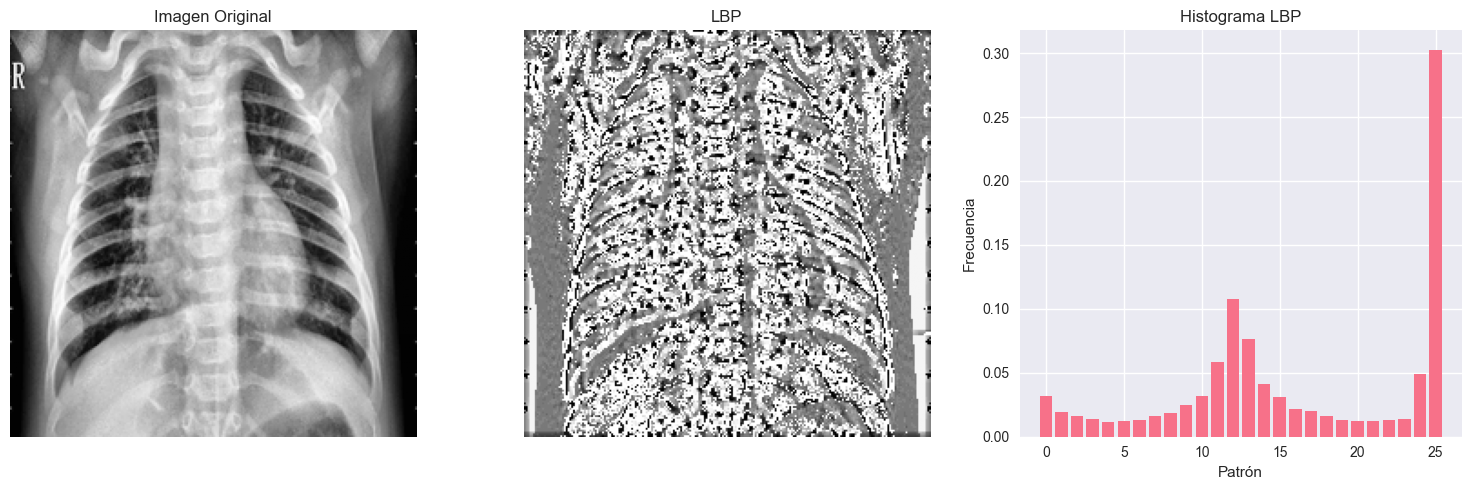

In [22]:
def extract_lbp_features(image, radius=3, n_points=24, method='uniform'):
    """
    Extrae características LBP de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
        radius: Radio del patrón circular
        n_points: Número de puntos de muestreo
        method: Método de cálculo ('uniform', 'default', 'ror', 'var')
    
    Returns:
        numpy.ndarray: Histograma de patrones LBP
    """
    try:
        # Convertir a uint8 si es necesario
        if image.dtype != np.uint8:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image
        
        # Calcular LBP
        lbp = local_binary_pattern(image_uint8, n_points, radius, method=method)
        
        # Calcular histograma
        if method == 'uniform':
            n_bins = n_points + 2
        else:
            n_bins = 2 ** n_points
        
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        
        return hist
    except Exception as e:
        print(f"Error extrayendo LBP: {e}")
        return None

# Demostrar extracción LBP
if dataset_info:
    sample_img_path = dataset_info['train']['PNEUMONIA'][1]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        lbp_features = extract_lbp_features(sample_img)
        print(f"Características LBP extraídas: {len(lbp_features)} dimensiones")
        
        # Visualizar LBP
        image_uint8 = (sample_img * 255).astype(np.uint8)
        lbp = local_binary_pattern(image_uint8, 24, 3, method='uniform')
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(sample_img, cmap='gray')
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        axes[1].imshow(lbp, cmap='gray')
        axes[1].set_title('LBP')
        axes[1].axis('off')
        
        axes[2].bar(range(len(lbp_features)), lbp_features)
        axes[2].set_title('Histograma LBP')
        axes[2].set_xlabel('Patrón')
        axes[2].set_ylabel('Frecuencia')
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / 'lbp_features_demo.png', dpi=300, bbox_inches='tight')
        plt.show()

La visualización es muy reveladora: la imagen LBP muestra los patrones locales de textura como una especie de huella digital de la radiografía. Se ven claramente diferentes tipos de patrones:

- Áreas uniformes (como dentro de los pulmones) aparecen más oscuras
- Bordes y transiciones (como las costillas) aparecen más claras
- Texturas complejas (como las áreas con neumonía) generan patrones únicos.

El histograma muestra que hay un patrón dominante. La barra alta del final, alrededor del patrón 25 que probablemente corresponde a texturas uniformes. Los otros picos más pequeños representan diferentes tipos de patrones de textura encontrados en la radiografía.

LBP es robusto a cambios de iluminación, así que va a funcionar bien incluso si las radiografías tienen diferentes niveles de contraste. Con solo 26 números, captura información muy específica sobre la textura local que puede diferenciar entre tejido pulmonar normal y patológico.


### 3.2 GLCM (Gray Level Co-occurrence Matrix)

In [23]:
def extract_glcm_features(image, distances=[1, 2, 3], angles=[0, 45, 90, 135]):
    """
    Extrae características GLCM de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
        distances: Lista de distancias
        angles: Lista de ángulos en grados
    
    Returns:
        numpy.ndarray: Vector de características GLCM
    """
    try:
        # Convertir a uint8 y reducir niveles de gris para eficiencia
        if image.dtype != np.uint8:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image
        
        # Reducir a 32 niveles de gris para eficiencia
        image_reduced = (image_uint8 // 8).astype(np.uint8)
        
        # Convertir ángulos a radianes
        angles_rad = [np.deg2rad(angle) for angle in angles]
        
        # Calcular GLCM
        glcm = graycomatrix(
            image_reduced, 
            distances=distances, 
            angles=angles_rad, 
            levels=32,
            symmetric=True, 
            normed=True
        )
        
        # Extraer propiedades
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        features = []
        
        for prop in properties:
            prop_values = graycoprops(glcm, prop)
            features.extend(prop_values.flatten())
        
        return np.array(features)
    except Exception as e:
        print(f"Error extrayendo GLCM: {e}")
        return None

# Demostrar extracción GLCM
if dataset_info:
    sample_img_path = dataset_info['train']['NORMAL'][2]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        glcm_features = extract_glcm_features(sample_img)
        print(f"Características GLCM extraídas: {len(glcm_features)} dimensiones")
        
        # Mostrar algunas características
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        features_per_prop = len(glcm_features) // len(properties)
        
        for i, prop in enumerate(properties):
            start_idx = i * features_per_prop
            end_idx = (i + 1) * features_per_prop
            prop_values = glcm_features[start_idx:end_idx]
            print(f"  {prop}: media = {np.mean(prop_values):.4f}, std = {np.std(prop_values):.4f}")

Características GLCM extraídas: 60 dimensiones
  contrast: media = 9.5246, std = 4.4373
  dissimilarity: media = 1.8939, std = 0.5456
  homogeneity: media = 0.4929, std = 0.0768
  energy: media = 0.1220, std = 0.0094
  correlation: media = 0.9388, std = 0.0288


GLCM Extrae 60 dimensiones de características, que es robusto para capturar propiedades de textura.

Los valores nos dan información muy valiosa sobre la estructura de la textura:

- Contraste: 9.52, Indica bastante variabilidad en los niveles de gris, típico de radiografías con estructuras definidas como costillas y pulmones
- Disimilitud: 1.89, Moderada, sugiere que hay diferencias claras entre píxeles vecinos pero no extremas
- Homogeneidad: 0.49, Nivel medio, significa que la imagen tiene áreas tanto uniformes como heterogéneas
- Energía: 0.12, relativamente baja, indica una textura con bastante variabilidad
- Correlación: 0.94 - Muy alta, sugiere que píxeles vecinos están fuertemente relacionados.

La desviación estándar nos dice que estas propiedades varían moderadamente across diferentes direcciones y distancias.

### 3.3 Filtros de Gabor

Características de Gabor extraídas: 60 dimensiones


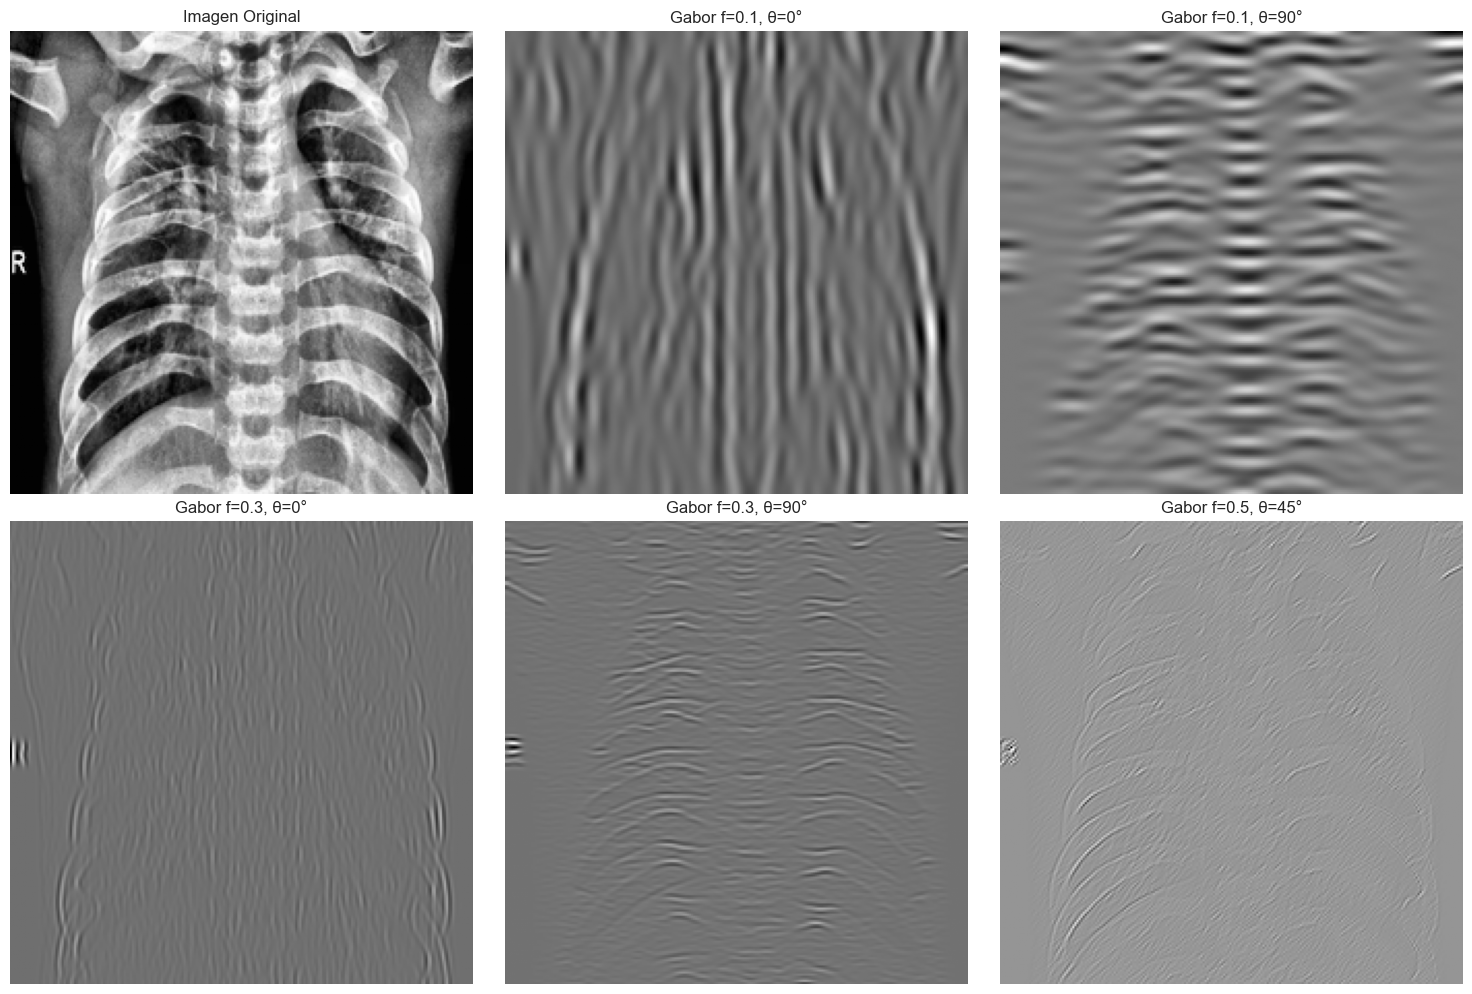

In [24]:
def extract_gabor_features(image, frequencies=[0.1, 0.3, 0.5], orientations=[0, 45, 90, 135]):
    """
    Extrae características usando filtros de Gabor.
    
    Args:
        image: Imagen en escala de grises (2D array)
        frequencies: Lista de frecuencias
        orientations: Lista de orientaciones en grados
    
    Returns:
        numpy.ndarray: Vector de características de Gabor
    """
    try:
        features = []
        
        for freq in frequencies:
            for orientation in orientations:
                # Convertir orientación a radianes
                theta = np.deg2rad(orientation)
                
                # Aplicar filtro de Gabor
                real, _ = gabor(image, frequency=freq, theta=theta)
                
                # Extraer estadísticas
                features.extend([
                    np.mean(real),
                    np.std(real),
                    np.mean(np.abs(real)),
                    np.max(real),
                    np.min(real)
                ])
        
        return np.array(features)
    except Exception as e:
        print(f"Error extrayendo características de Gabor: {e}")
        return None

# Demostrar extracción de Gabor
if dataset_info:
    sample_img_path = dataset_info['train']['PNEUMONIA'][2]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        gabor_features = extract_gabor_features(sample_img)
        print(f"Características de Gabor extraídas: {len(gabor_features)} dimensiones")
        
        # Visualizar algunos filtros de Gabor
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes[0, 0].imshow(sample_img, cmap='gray')
        axes[0, 0].set_title('Imagen Original')
        axes[0, 0].axis('off')
        
        # Mostrar filtros con diferentes frecuencias y orientaciones
        gabor_params = [(0.1, 0), (0.1, 90), (0.3, 0), (0.3, 90), (0.5, 45)]
        
        for i, (freq, orientation) in enumerate(gabor_params):
            theta = np.deg2rad(orientation)
            real, _ = gabor(sample_img, frequency=freq, theta=theta)
            
            row = (i + 1) // 3
            col = (i + 1) % 3
            axes[row, col].imshow(real, cmap='gray')
            axes[row, col].set_title(f'Gabor f={freq}, θ={orientation}°')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / 'gabor_features_demo.png', dpi=300, bbox_inches='tight')
        plt.show()

- Gabor f=0.1, θ=0°: Detecta patrones verticales de baja frecuencia - se ven claramente las costillas como líneas verticales onduladas
- Gabor f=0.1, θ=90°: Captura patrones horizontales - muestra las estructuras que van de lado a lado
- Gabor f=0.3, θ=0°: Frecuencia media, orientación vertical - detecta detalles más finos en dirección vertical
- Gabor f=0.3, θ=90°: Frecuencia media, horizontal - patrones ondulados que siguen estructuras anatómicas
- Gabor f=0.5, θ=45°: Alta frecuencia, diagonal - captura detalles muy finos en ángulo diagonal

### 3.4 Estadísticas de Primer Orden

In [25]:
def extract_statistical_features(image):
    """
    Extrae estadísticas de primer orden de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
    
    Returns:
        dict: Diccionario con estadísticas
    """
    try:
        pixel_values = image.flatten()
        
        # Remover valores NaN o infinitos
        pixel_values = pixel_values[np.isfinite(pixel_values)]
        
        if len(pixel_values) == 0:
            return None
        
        # Calcular estadísticas
        stats = {
            'mean': np.mean(pixel_values),
            'std': np.std(pixel_values),
            'variance': np.var(pixel_values),
            'skewness': skew(pixel_values),
            'kurtosis': kurtosis(pixel_values),
            'entropy': -np.sum(np.histogram(pixel_values, bins=256, density=True)[0] * 
                             np.log2(np.histogram(pixel_values, bins=256, density=True)[0] + 1e-10)),
            'min': np.min(pixel_values),
            'max': np.max(pixel_values),
            'range': np.max(pixel_values) - np.min(pixel_values),
            'percentile_25': np.percentile(pixel_values, 25),
            'percentile_75': np.percentile(pixel_values, 75)
        }
        
        return stats
    except Exception as e:
        print(f"Error extrayendo estadísticas: {e}")
        return None

# Demostrar extracción de estadísticas
if dataset_info:
    sample_img_path = dataset_info['train']['NORMAL'][3]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        stats = extract_statistical_features(sample_img)
        print("Estadísticas de primer orden extraídas:")
        for key, value in stats.items():
            print(f"  {key}: {value:.4f}")

Estadísticas de primer orden extraídas:
  mean: 0.5235
  std: 0.2416
  variance: 0.0584
  skewness: -0.2563
  kurtosis: -0.9182
  entropy: -43.7811
  min: 0.0039
  max: 1.0000
  range: 0.9961
  percentile_25: 0.3333
  percentile_75: 0.7176


Estadísticas básicas:

- Media: 0.52 - La imagen está bien centrada en el rango [0,1]
- Desviación estándar: 0.24 - Variabilidad moderada de intensidades
- Varianza: 0.058 - Confirma la variabilidad moderada

Forma de la distribución:

- Skewness: -0.26 - Ligeramente sesgada hacia valores más altos (más píxeles claros)
- Kurtosis: -0.92 - Distribución más "plana" que una normal (platykurtic)

Información y rangos:

- Entropía: -43.78 - Nivel de "desorden" o información en la imagen
- Rango: 0.996 - Usa casi todo el rango [0,1], buen contraste
- Percentiles 25/75: 0.33 y 0.72 - Confirma buena distribución de intensidades

Estos valores nos dicen que es una radiografía con buen contraste y distribución balanceada de intensidades. El skewness negativo sugiere que tiene más áreas claras que muy oscuras.

## 4. Función Completa de Extracción de Características

In [27]:
def extract_all_features(image):
    """
    Extrae todas las características de una imagen.
    
    Args:
        image: Imagen en escala de grises (2D array)
    
    Returns:
        dict: Diccionario con todas las características
    """
    features = {}
    
    # Descriptores de forma
    hog_feat = extract_hog_features(image)
    if hog_feat is not None:
        features['hog'] = hog_feat
    
    hu_feat = extract_hu_moments(image)
    if hu_feat is not None:
        features['hu_moments'] = hu_feat
    
    contour_feat = extract_contour_features(image)
    if contour_feat is not None:
        features['contour'] = list(contour_feat.values())
    
    # Descriptores de textura
    lbp_feat = extract_lbp_features(image)
    if lbp_feat is not None:
        features['lbp'] = lbp_feat
    
    glcm_feat = extract_glcm_features(image)
    if glcm_feat is not None:
        features['glcm'] = glcm_feat
    
    gabor_feat = extract_gabor_features(image)
    if gabor_feat is not None:
        features['gabor'] = gabor_feat
    
    stats_feat = extract_statistical_features(image)
    if stats_feat is not None:
        features['statistics'] = list(stats_feat.values())
    
    return features

# Demostrar extracción completa
if dataset_info:
    sample_img_path = dataset_info['train']['PNEUMONIA'][3]
    sample_img = preprocess_image(sample_img_path, IMG_SIZE)
    
    if sample_img is not None:
        all_features = extract_all_features(sample_img)
        
        print("Resumen de características extraídas:")
        total_dims = 0
        for feat_type, feat_vector in all_features.items():
            dims = len(feat_vector)
            total_dims += dims
            print(f"  {feat_type}: {dims} dimensiones")
        
        print(f"\nTotal de características: {total_dims} dimensiones")

Resumen de características extraídas:
  hog: 26244 dimensiones
  hu_moments: 7 dimensiones
  contour: 7 dimensiones
  lbp: 26 dimensiones
  glcm: 60 dimensiones
  gabor: 60 dimensiones
  statistics: 11 dimensiones

Total de características: 26415 dimensiones


## 5. Extracción de Características del Dataset Completo

In [28]:
def process_dataset_features(dataset_info, max_samples_per_class=None):
    """
    Extrae características de todo el dataset.
    
    Args:
        dataset_info: Información del dataset
        max_samples_per_class: Número máximo de muestras por clase (None para todas)
    
    Returns:
        dict: Dataset con características extraídas
    """
    if not dataset_info:
        return None
    
    processed_features = {
        'train': {'features': [], 'labels': [], 'filenames': []},
        'test': {'features': [], 'labels': [], 'filenames': []},
        'val': {'features': [], 'labels': [], 'filenames': []}
    }
    
    class_to_label = {'NORMAL': 0, 'PNEUMONIA': 1}
    
    print("Extrayendo características del dataset completo...")
    
    for split in ['train', 'test', 'val']:
        print(f"\nProcesando conjunto: {split.upper()}")
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            images = dataset_info[split][class_name]
            label = class_to_label[class_name]
            
            # Limitar número de muestras si se especifica
            if max_samples_per_class is not None and len(images) > max_samples_per_class:
                images = images[:max_samples_per_class]
            
            print(f"  {class_name}: procesando {len(images)} imágenes")
            
            for img_path in tqdm(images, desc=f"    Extrayendo {class_name}"):
                # Preprocesar imagen
                processed_img = preprocess_image(img_path, IMG_SIZE)
                
                if processed_img is not None:
                    # Extraer características
                    features = extract_all_features(processed_img)
                    
                    if features:
                        # Concatenar todas las características en un vector
                        feature_vector = []
                        for feat_type in ['hog', 'hu_moments', 'contour', 'lbp', 'glcm', 'gabor', 'statistics']:
                            if feat_type in features:
                                feature_vector.extend(features[feat_type])
                        
                        if len(feature_vector) > 0:
                            processed_features[split]['features'].append(feature_vector)
                            processed_features[split]['labels'].append(label)
                            processed_features[split]['filenames'].append(str(img_path))
    
    # Convertir a arrays numpy
    for split in ['train', 'test', 'val']:
        if len(processed_features[split]['features']) > 0:
            processed_features[split]['features'] = np.array(processed_features[split]['features'])
            processed_features[split]['labels'] = np.array(processed_features[split]['labels'])
            
            print(f"{split.upper()} - Forma final: {processed_features[split]['features'].shape}")
    
    return processed_features

# Procesar una muestra pequeña del dataset para prueba
print("NOTA: Procesando una muestra pequeña para demostración.")
print("Para el dataset completo, modifica max_samples_per_class=None")

sample_features = process_dataset_features(dataset_info, max_samples_per_class=50)

NOTA: Procesando una muestra pequeña para demostración.
Para el dataset completo, modifica max_samples_per_class=None
Extrayendo características del dataset completo...

Procesando conjunto: TRAIN
  NORMAL: procesando 50 imágenes


    Extrayendo NORMAL: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


  PNEUMONIA: procesando 50 imágenes


    Extrayendo PNEUMONIA: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]



Procesando conjunto: TEST
  NORMAL: procesando 50 imágenes


    Extrayendo NORMAL: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


  PNEUMONIA: procesando 50 imágenes


    Extrayendo PNEUMONIA: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]



Procesando conjunto: VAL
  NORMAL: procesando 8 imágenes


    Extrayendo NORMAL: 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


  PNEUMONIA: procesando 8 imágenes


    Extrayendo PNEUMONIA: 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


TRAIN - Forma final: (100, 26415)
TEST - Forma final: (100, 26415)
VAL - Forma final: (16, 26415)


In [29]:
# Guardar características extraídas
if sample_features:
    print("\nGuardando características extraídas...")
    
    for split in ['train', 'test', 'val']:
        if len(sample_features[split]['features']) > 0:
            # Guardar características
            np.save(FEATURES_PATH / f'{split}_features.npy', sample_features[split]['features'])
            np.save(FEATURES_PATH / f'{split}_labels.npy', sample_features[split]['labels'])
            
            # Guardar nombres de archivos
            with open(FEATURES_PATH / f'{split}_filenames.json', 'w') as f:
                json.dump(sample_features[split]['filenames'], f, indent=2)
    
    # Guardar metadatos
    metadata = {
        'feature_extraction_params': {
            'img_size': IMG_SIZE,
            'hog_orientations': 9,
            'lbp_radius': 3,
            'lbp_n_points': 24,
            'glcm_distances': [1, 2, 3],
            'glcm_angles': [0, 45, 90, 135],
            'gabor_frequencies': [0.1, 0.3, 0.5],
            'gabor_orientations': [0, 45, 90, 135]
        },
        'feature_dimensions': {
            'total_per_image': sample_features['train']['features'].shape[1] if len(sample_features['train']['features']) > 0 else 0
        },
        'class_mapping': {'NORMAL': 0, 'PNEUMONIA': 1}
    }
    
    with open(FEATURES_PATH / 'metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Características guardadas en: {FEATURES_PATH}")
    print("Metadatos guardados con parámetros de extracción")




Guardando características extraídas...
Características guardadas en: c:\Users\juanm.sanchez\OneDrive - DISLICORES\Escritorio\Maestría\Semestre 2\Computer Vision\Trabajo 3\proyecto_clasificacion_neumonia\data\features
Metadatos guardados con parámetros de extracción
